# LaBraM — PhysioNet EEGMMIDB fine-tuning (ALL runs → Left vs Right)

Goal: fine-tune a pretrained LaBraM checkpoint on PhysioNet EEGMMIDB using **all relevant runs**, but predict only **Left vs Right** (ignore imagined vs real).

In [1]:
import os, sys, random
from pathlib import Path
import numpy as np
import torch

PROJECT_ROOT = Path.cwd()
LABRAM_ROOT = PROJECT_ROOT / "LaBraM"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("LABRAM_ROOT:", LABRAM_ROOT, "exists?", LABRAM_ROOT.exists())

# Make LaBraM importable
if str(LABRAM_ROOT) not in sys.path:
    sys.path.insert(0, str(LABRAM_ROOT))

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("torch:", torch.__version__)

PROJECT_ROOT: /home/jovyan/projects/neuro-eeg
LABRAM_ROOT: /home/jovyan/projects/neuro-eeg/LaBraM exists? True
Device: cuda
torch: 2.8.0+cu128


## Data location

We use the PhysioNet EEGMMIDB dataset from the repo's `data/` folder.

Expected root:
`data/physionet.org/files/eegmmidb/1.0.0`

In [2]:
DATA_ROOT = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"
print("DATA_ROOT:", DATA_ROOT)
print("Exists?", DATA_ROOT.exists())

# Optional: list first few subject dirs
if DATA_ROOT.exists():
    subdirs = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir() and p.name.startswith("S")])
    print("Num subject folders found:", len(subdirs))
    print("First 5 subject folders:", subdirs[:5])

DATA_ROOT: /home/jovyan/projects/neuro-eeg/data/physionet.org/files/eegmmidb/1.0.0
Exists? True
Num subject folders found: 109
First 5 subject folders: ['S001', 'S002', 'S003', 'S004', 'S005']


## Dataloader for ALL runs (3,4,7,8,11,12) → Left vs Right

The dataloader:
- reads EDF with MNE
- selects the BCI-style 22 channels
- preprocesses + resamples to 200 Hz
- extracts 4-second segments
- returns tensors shaped **(22, 4, 200)** for LaBraM

## Imports: LaBraM model registration + new ALL-runs dataloader

- `modeling_finetune` registers the LaBraM models into `timm`
- `EEGMMIDBLaBraMAllRunsLRDataset` loads PhysioNet EEGMMIDB runs 3,4,7,8,11,12 and labels only Left/Right

In [3]:
import timm

# Important: this import registers the model names into timm
import modeling_finetune  # from LaBraM/

from dataloader.eegmmidb_labram_dataset_allruns_2class import (
    EEGMMIDBLaBraMAllRunsLRDataset,
    PreprocConfig,
    BCI22_CHANNELS,
    LABRAM_64_MAP,
)

print("LaBraM model registered?", "labram_base_patch200_200" in timm.list_models())
print("Num timm models:", len(timm.list_models()))

LaBraM model registered? True
Num timm models: 615


## Dataset: PhysioNet EEGMMIDB (All motor runs → Left vs Right)

We load **all left/right motor-related runs** from the PhysioNet EEGMMIDB dataset and **collapse imagined and real movements into a single binary task** (Left vs Right).

### Runs used

According to the official EEGMMIDB protocol:

- **Real (executed) left / right hand**
  - Runs **3, 7, 11**

- **Imagined left / right hand**
  - Runs **4, 8, 12**

In this notebook, we use runs:

- **3, 4, 7, 8, 11, 12** → left/right hand motor tasks  
  (both *imagined* and *real*)

### Label mapping

- **0 = Left hand** (T1)
- **1 = Right hand** (T2)

### Notes

- Imagined vs real movement is **intentionally ignored** at this stage.
- The model is trained to predict **hand laterality only (Left vs Right)**.
- Task type (*imagined* vs *real*) is retained in metadata and used **only for post-hoc analysis**, not for training.

In [4]:
from pathlib import Path
import torch

PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=None,          # all subjects
    runs=[3, 4, 7, 8, 11, 12],       # imagined + real, left/right
    t_min=0.0,
    t_max=4.0,              # 4 seconds → 800 samples @ 200 Hz
    normalization=True,
    is_train=True,
    add_noise_std=0.0,
    preproc=PreprocConfig(
        target_sfreq=200.0,
        notch_hz=50.0,
        l_freq=0.1,
        h_freq=75.0,
        reref="average",
        to_microvolts=True,
    ),
)

print("Dataset length:", len(ds))

sample = ds[0]
x = sample["inputs"]
y = sample["labels"]
meta = sample["meta"]

print("x shape:", x.shape)        # (22, 800)
print("label:", y)
print("label_name:", meta["label_name"])
print("run:", meta["run"])
print("task_type:", meta["task_type"])

/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/data

Dataset length: 9844
x shape: torch.Size([22, 4, 200])
label: tensor(1)
label_name: T2
run: 3
task_type: real


In [5]:
import numpy as np
from collections import Counter

runs = [m["run"] for m in ds.metas]
tasks = [m["task_type"] for m in ds.metas]
labels = [int(y) for y in ds.labels]
label_names = [m["label_name"] for m in ds.metas]

print("Total samples:", len(ds))
print("Runs present:", sorted(set(runs)))
print("Run counts:", dict(sorted(Counter(runs).items())))

print("\nTask types present:", sorted(set(tasks)))
print("Task type counts:", dict(sorted(Counter(tasks).items())))

print("\nLabel ids present:", sorted(set(labels)))
print("Label counts:", dict(sorted(Counter(labels).items())))

print("\nLabel_name counts:", dict(sorted(Counter(label_names).items())))

# sanity: do we have both imagined and real, and all 4 runs?
expected_runs = {3, 4, 7, 8, 11, 12}
print("\nMissing runs:", sorted(expected_runs - set(runs)))

Total samples: 9844
Runs present: [3, 4, 7, 8, 11, 12]
Run counts: {3: 1647, 4: 1640, 7: 1640, 8: 1637, 11: 1640, 12: 1640}

Task types present: ['imagined', 'real']
Task type counts: {'imagined': 4917, 'real': 4927}

Label ids present: [0, 1]
Label counts: {0: 4950, 1: 4894}

Label_name counts: {'T1': 4950, 'T2': 4894}

Missing runs: []


## Ensure reproducibility

In [6]:
# --- Reproducibility guard (run BEFORE dataset split / dataloaders) ---
import os, random
import numpy as np
import torch

SEED = 5  # change if you want a different run, but keep fixed for debugging
print("Using SEED =", SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# CUDNN controls (determinism vs speed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# For PyTorch >= 2.0 (more deterministic, may throw if an op has no deterministic impl)
try:
    torch.use_deterministic_algorithms(False)  # set True if you want strict determinism (can error)
except Exception as e:
    print("torch.use_deterministic_algorithms not available:", e)

print("torch initial seed:", torch.initial_seed())

Using SEED = 5
torch initial seed: 5


## Train/Val/Test split: split by SUBJECT

We must split by **subject**, not by individual windows, otherwise we leak person-specific patterns
into validation/test and inflate accuracy.

So we will:
- pick a set of subjects for train / val / test
- build **three datasets** (same preprocessing, different subject lists)

In [8]:
from dataloader.eegmmidb_labram_physionet_allruns_2class import EEGMMIDBLaBraMAllRunsLRDataset, PreprocConfig
import numpy as np

# --- discover all subjects from the dataset we already loaded
all_subjects = sorted({m["subject"] for m in ds.metas})
print("Num subjects found:", len(all_subjects))
print("First 10 subjects:", all_subjects[:10])

# --- subject-wise split (80/10/10)
rng = np.random.default_rng(SEED)
perm = rng.permutation(all_subjects)

n = len(perm)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_subjects = sorted(perm[:n_train].tolist())
val_subjects = sorted(perm[n_train:n_train + n_val].tolist())
test_subjects = sorted(perm[n_train + n_val:].tolist())

print("\nSplit sizes:")
print("train subjects:", len(train_subjects))
print("val subjects:  ", len(val_subjects))
print("test subjects: ", len(test_subjects))

# --- reuse the same preprocessing config and run list
preproc = PreprocConfig(
    target_sfreq=200.0,
    notch_hz=50.0,
    l_freq=0.1,
    h_freq=75.0,
    reref="average",
    to_microvolts=True,
)

train_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=train_subjects,
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=True,
    add_noise_std=0.02,   # mild noise aug like before
    preproc=preproc,
)

val_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=val_subjects,
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=False,
    add_noise_std=0.0,
    preproc=preproc,
)

test_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=test_subjects,
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=False,
    add_noise_std=0.0,
    preproc=preproc,
)

print("\nDataset lengths:")
print("train:", len(train_ds))
print("val:  ", len(val_ds))
print("test: ", len(test_ds))

Num subjects found: 109
First 10 subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Split sizes:
train subjects: 87
val subjects:   10
test subjects:  12


/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_physionet_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_physionet_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_physionet_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_physionet_allruns_2class.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-


Dataset lengths:
train: 7882
val:   882
test:  1080


In [9]:
import warnings
from torch.utils.data import DataLoader

# Keep notebook output readable
warnings.filterwarnings("ignore", message="NOTE: pick_channels\\(\\) is a legacy function.*")
warnings.filterwarnings("ignore", message="Limited .* annotation\\(s\\).*expanding outside the data range.*")

BATCH_SIZE = 32
NUM_WORKERS = 6  # adjust if your JupyterHub is tight

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick sanity batch
batch = next(iter(train_loader))
print("Batch inputs:", tuple(batch["inputs"].shape), "Batch labels:", tuple(batch["labels"].shape))
print("Label min/max:", int(batch["labels"].min()), int(batch["labels"].max()))

meta = batch["meta"]

print("meta type:", type(meta))
print("meta keys:", list(meta.keys()))

# show one meta field (first 5 entries)
any_key = list(meta.keys())[0]
print(f"\nExample meta field '{any_key}' (first 5):", meta[any_key][:5])

Batch inputs: (32, 22, 4, 200) Batch labels: (32,)
Label min/max: 0 1
meta type: <class 'dict'>
meta keys: ['subject', 'run', 'task_type', 'label_name', 'sfreq', 'ch_names', 't_min', 't_max', 'path']

Example meta field 'subject' (first 5): tensor([28, 55, 84, 20, 88])


## LaBraM channel mapping (22 channels → LaBraM positional indices)

LaBraM was trained with a channel-position embedding table, so we pass an `input_chans` index list.

Key detail:
- LaBraM expects `input_chans` to include a dummy **0** index at the front (for the CLS token position usage in their code).
- Then we add the 22 mapped channel indices (from `LABRAM_64_MAP`).

So `input_chans` will have length **23**:
`[0] + [mapped indices for the 22 BCI channels]`

In [10]:
import sys
from pathlib import Path
from collections import OrderedDict
import torch
import timm

# --- Ensure LaBraM is importable + registers models
PROJECT_ROOT = Path.cwd()
LABRAM_ROOT = PROJECT_ROOT / "LaBraM"
if str(LABRAM_ROOT) not in sys.path:
    sys.path.insert(0, str(LABRAM_ROOT))

import modeling_finetune  # registers into timm

# --- input_chans: [0] + 22 mapped indices
mapped = [LABRAM_64_MAP[ch] for ch in BCI22_CHANNELS]
input_chans = torch.tensor([0] + mapped, dtype=torch.long)  # (23,)
print("input_chans shape:", tuple(input_chans.shape), "first 10:", input_chans[:10].tolist())

# --- Build LaBraM model for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    "labram_base_patch200_200",
    pretrained=False,
    num_classes=2,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=True,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=True,
).to(device)

# --- Load pretrained checkpoint (labram-base.pth)
ckpt_path = PROJECT_ROOT / "LaBraM" / "checkpoints" / "labram-base.pth"
print("Loading checkpoint:", ckpt_path)

checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

checkpoint_model = checkpoint.get("model", checkpoint)

# Strip 'student.' prefix if present
if isinstance(checkpoint_model, dict) and any(k.startswith("student.") for k in checkpoint_model.keys()):
    new_dict = OrderedDict()
    for k, v in checkpoint_model.items():
        if k.startswith("student."):
            new_dict[k[len("student."):]] = v
    checkpoint_model = new_dict
    print("Stripped 'student.' prefix.")

# Remove classifier head if mismatched
state_dict = model.state_dict()
for k in ["head.weight", "head.bias"]:
    if k in checkpoint_model and k in state_dict and checkpoint_model[k].shape != state_dict[k].shape:
        del checkpoint_model[k]

# Remove relative_position_index buffers if present
for k in list(checkpoint_model.keys()):
    if "relative_position_index" in k:
        checkpoint_model.pop(k)

missing, unexpected = model.load_state_dict(checkpoint_model, strict=False)
print("Checkpoint loaded. Missing:", len(missing), "Unexpected:", len(unexpected))
print("Missing (first 8):", missing[:8])
print("Unexpected (first 8):", unexpected[:8])

model.eval()

# --- Forward pass sanity on one batch
batch = next(iter(train_loader))
x = batch["inputs"][:2].to(device)  # (B, 22, 4, 200)

with torch.no_grad():
    logits = model(x, input_chans=input_chans.to(device))

print("Forward OK. logits shape:", tuple(logits.shape))
print("logits:", logits.detach().cpu())

input_chans shape: (23,) first 10: [0, 2, 10, 11, 12, 13, 14, 26, 27, 28]
Loading checkpoint: /home/jovyan/projects/neuro-eeg/LaBraM/checkpoints/labram-base.pth
Stripped 'student.' prefix.
Checkpoint loaded. Missing: 28 Unexpected: 5
Missing (first 8): ['blocks.0.attn.q_bias', 'blocks.0.attn.v_bias', 'blocks.1.attn.q_bias', 'blocks.1.attn.v_bias', 'blocks.2.attn.q_bias', 'blocks.2.attn.v_bias', 'blocks.3.attn.q_bias', 'blocks.3.attn.v_bias']
Unexpected (first 8): ['mask_token', 'lm_head.weight', 'lm_head.bias', 'norm.weight', 'norm.bias']
Forward OK. logits shape: (2, 2)
logits: tensor([[-5.5914e-04, -4.7654e-05],
        [-5.3130e-04, -8.6629e-06]])


## Training setup (binary Left vs Right)

Before training, we rebuild the model with `qkv_bias=False` so that checkpoint loading matches
and we avoid the extra "missing q_bias/v_bias" keys.

Then we:
- set up optimizer (AdamW)
- set up a simple training loop with validation accuracy
- save the best model to `training_logs/labram_physionet_lr_allruns/`

In [18]:
import os
import torch
import timm
from collections import OrderedDict
from pathlib import Path

OUT_DIR = Path.cwd() / "training_logs" / "labram_physionet_imagined_allruns"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model (match checkpoint better by disabling qkv_bias)
model = timm.create_model(
    "labram_base_patch200_200",
    pretrained=False,
    num_classes=2,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=True,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=False,   # <--- important
).to(device)

# --- Load checkpoint again
ckpt_path = Path.cwd() / "LaBraM" / "checkpoints" / "labram-base.pth"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)
checkpoint_model = checkpoint.get("model", checkpoint)

# Strip 'student.' prefix if present
if isinstance(checkpoint_model, dict) and any(k.startswith("student.") for k in checkpoint_model.keys()):
    new_dict = OrderedDict()
    for k, v in checkpoint_model.items():
        if k.startswith("student."):
            new_dict[k[len("student."):]] = v
    checkpoint_model = new_dict

# Remove classifier head if mismatched
state_dict = model.state_dict()
for k in ["head.weight", "head.bias"]:
    if k in checkpoint_model and k in state_dict and checkpoint_model[k].shape != state_dict[k].shape:
        del checkpoint_model[k]

# Remove relative_position_index buffers if present
for k in list(checkpoint_model.keys()):
    if "relative_position_index" in k:
        checkpoint_model.pop(k)

missing, unexpected = model.load_state_dict(checkpoint_model, strict=False)
print("Checkpoint loaded. Missing:", len(missing), "Unexpected:", len(unexpected))
print("Missing (first 10):", missing[:10])
print("Unexpected (first 10):", unexpected[:10])

# --- Optimizer (repo-style: layer-wise lr decay)
LR = 1e-4
WEIGHT_DECAY = 0.05
LAYER_DECAY = 0.95   # match repo flag --layer_decay 0.65

import re

def get_layer_id(name: str, num_blocks: int) -> int:
    # embeddings / tokens / positional encodings
    if name.startswith("patch_embed") or name in ["cls_token", "pos_embed"] or "pos_embed" in name:
        return 0
    m = re.match(r"blocks\.(\d+)\.", name)
    if m:
        return int(m.group(1)) + 1
    return num_blocks + 1  # head / fc_norm / etc.

def build_param_groups(model, base_lr, weight_decay, layer_decay):
    num_blocks = len(model.blocks)
    max_layer_id = num_blocks + 1

    param_groups = {}
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue

        layer_id = get_layer_id(name, num_blocks)
        lr_scale = layer_decay ** (max_layer_id - layer_id)

        # no weight decay for biases / norms (typical repo setup)
        is_no_decay = (name.endswith(".bias") or p.ndim == 1)

        key = (layer_id, is_no_decay)
        if key not in param_groups:
            param_groups[key] = {
                "params": [],
                "lr": base_lr * lr_scale,
                "weight_decay": 0.0 if is_no_decay else weight_decay,
            }
        param_groups[key]["params"].append(p)

    return list(param_groups.values())

param_groups = build_param_groups(model, LR, WEIGHT_DECAY, LAYER_DECAY)

optimizer = torch.optim.AdamW(
    param_groups,
    betas=(0.9, 0.999),
    eps=1e-8,
)

criterion = torch.nn.CrossEntropyLoss()

print("Ready to train. Example param count:", sum(p.numel() for p in model.parameters())/1e6, "M params")

OUT_DIR: /home/jovyan/projects/neuro-eeg/training_logs/labram_physionet_imagined_allruns
Checkpoint loaded. Missing: 4 Unexpected: 5
Missing (first 10): ['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias']
Unexpected (first 10): ['mask_token', 'lm_head.weight', 'lm_head.bias', 'norm.weight', 'norm.bias']
Ready to train. Example param count: 5.820338 M params


## Train LaBraM on PhysioNet EEGMMIDB (runs 3,4,7,8) — Left vs Right

We will train for a modest number of epochs first (e.g. 10),
track validation accuracy, and save the best checkpoint to:

`training_logs/labram_physionet_lr_allruns/best.pth`

In [20]:
import time
import math
import numpy as np
import torch
from torch.optim.lr_scheduler import LambdaLR

EPOCHS = 100
PRINT_EVERY = 100  # steps
WARMUP_EPOCHS = 5
MIN_LR = 1e-6  # absolute minimum LR floor (approx)

def run_eval(model, loader, device, input_chans):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    n = 0

    with torch.no_grad():
        for batch in loader:
            x = batch["inputs"].to(device, non_blocking=True)
            y = batch["labels"].to(device, non_blocking=True)

            logits = model(x, input_chans=input_chans.to(device))
            loss = criterion(logits, y)

            total_loss += float(loss.item()) * x.size(0)
            n += x.size(0)

            preds = logits.argmax(dim=1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = float((all_preds == all_labels).mean())
    return total_loss / max(n, 1), acc


# -------------------------
# Scheduler (warmup + cosine) that behaves correctly with *multiple param groups*
# Key idea: LambdaLR multiplies each group's *initial lr* by lr_factor(step).
# We include a MIN_LR floor by expressing it relative to the *max initial lr*.
# -------------------------
steps_per_epoch = len(train_loader)
total_steps = EPOCHS * steps_per_epoch
warmup_steps = WARMUP_EPOCHS * steps_per_epoch

# IMPORTANT: capture initial LRs BEFORE training starts
initial_group_lrs = [g["lr"] for g in optimizer.param_groups]
base_lr_max = float(max(initial_group_lrs))  # the true "base" lr target (largest group)
min_ratio = float(MIN_LR / base_lr_max) if base_lr_max > 0 else 0.0

def lr_factor(step: int) -> float:
    # returns multiplier in [min_ratio, 1]
    if step < warmup_steps:
        # warmup from 0 -> 1
        return step / max(1, warmup_steps)

    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)  # 0 -> 1
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))  # 1 -> 0
    return cosine * (1.0 - min_ratio) + min_ratio

scheduler = LambdaLR(optimizer, lr_lambda=lr_factor)

# -------------------------
# Early stopping
# -------------------------
best_val_acc = -1.0
PATIENCE = 6
min_delta = 1e-4
no_improve = 0
best_path = OUT_DIR / "best.pth"

global_step = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # (Optional but useful) quick gradient sanity check once per epoch
    grad_head_mean = None

    for step, batch in enumerate(train_loader):
        x = batch["inputs"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits = model(x, input_chans=input_chans.to(device))
        loss = criterion(logits, y)

        loss.backward()

        # record grad sanity once per epoch (first step)
        if step == 0:
            try:
                g = model.head.weight.grad
                grad_head_mean = float(g.abs().mean().item()) if g is not None else None
            except Exception:
                grad_head_mean = None

        optimizer.step()
        scheduler.step()
        global_step += 1

        # stats
        bs = x.size(0)
        running_loss += float(loss.item()) * bs
        preds = logits.argmax(dim=1)
        running_correct += int((preds == y).sum().item())
        running_total += bs

        if step % PRINT_EVERY == 0:
            lrs = [g["lr"] for g in optimizer.param_groups]
            print(
                f"epoch {epoch:02d} step {step:04d} | "
                f"loss {loss.item():.4f} | "
                f"lr(min/max) {min(lrs):.2e}/{max(lrs):.2e}"
            )

    train_loss = running_loss / max(running_total, 1)
    train_acc = running_correct / max(running_total, 1)

    val_loss, val_acc = run_eval(model, val_loader, device, input_chans)

    # save best
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "val_acc": val_acc,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "train_loss": train_loss,
                "initial_group_lrs": initial_group_lrs,
            },
            best_path,
        )
    else:
        no_improve += 1

    dt = time.time() - t0
    grad_str = f"{grad_head_mean:.2e}" if isinstance(grad_head_mean, float) else "None"
    print(
        f"epoch {epoch:02d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"best {best_val_acc:.4f} | "
        f"head_grad(mean) {grad_str} | "
        f"{dt:.1f}s"
    )

    if no_improve >= PATIENCE:
        print(f"Early stopping: no improvement for {PATIENCE} epochs. Best val_acc={best_val_acc:.4f}")
        break

print("Saved best checkpoint to:", best_path)

epoch 01 step 0000 | loss 0.6965 | lr(min/max) 4.17e-08/8.13e-08
epoch 01 step 0100 | loss 0.6886 | lr(min/max) 4.22e-06/8.21e-06
epoch 01 step 0200 | loss 0.6925 | lr(min/max) 8.39e-06/1.63e-05
epoch 01 | train loss 0.6933 acc 0.4977 | val loss 0.6932 acc 0.4977 | best 0.4977 | head_grad(mean) 3.35e-02 | 10.8s
epoch 02 step 0000 | loss 0.6932 | lr(min/max) 1.03e-05/2.01e-05
epoch 02 step 0100 | loss 0.6929 | lr(min/max) 1.45e-05/2.82e-05
epoch 02 step 0200 | loss 0.6963 | lr(min/max) 1.87e-05/3.63e-05
epoch 02 | train loss 0.6932 acc 0.5018 | val loss 0.6933 acc 0.4977 | best 0.4977 | head_grad(mean) 6.93e-03 | 10.9s
epoch 03 step 0000 | loss 0.6906 | lr(min/max) 2.06e-05/4.01e-05
epoch 03 step 0100 | loss 0.6940 | lr(min/max) 2.47e-05/4.82e-05
epoch 03 step 0200 | loss 0.6929 | lr(min/max) 2.89e-05/5.63e-05
epoch 03 | train loss 0.6934 acc 0.4883 | val loss 0.6933 acc 0.4977 | best 0.4977 | head_grad(mean) 2.95e-02 | 10.9s
epoch 04 step 0000 | loss 0.6906 | lr(min/max) 3.08e-05/6.01e

## Test set evaluation (best checkpoint)

We load the best checkpoint and evaluate on the held-out **test subjects**.
We report:
- test accuracy
- confusion matrix (plotted + annotated)
- per-class accuracy

Loading best checkpoint: /home/jovyan/projects/neuro-eeg/training_logs/labram_physionet_imagined_allruns/best.pth
TEST acc: 0.7815  (n=1080)
Confusion matrix (rows=true, cols=pred):
[[391 158]
 [ 78 453]]
class 0 (Left (T1)) acc: 0.7122  (n=549)
class 1 (Right (T2)) acc: 0.8531  (n=531)


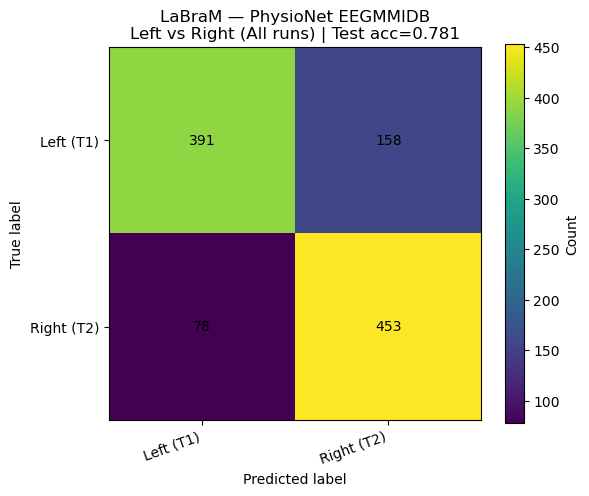

In [21]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

BEST_PATH = OUT_DIR / "best.pth"
print("Loading best checkpoint:", BEST_PATH)

ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x = batch["inputs"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        logits = model(x, input_chans=input_chans.to(device))
        preds = logits.argmax(dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = float((all_preds == all_labels).mean())
print(f"TEST acc: {test_acc:.4f}  (n={len(all_labels)})")

# Confusion matrix: rows=true, cols=pred
cm = np.zeros((2, 2), dtype=int)
for t, p in zip(all_labels, all_preds):
    cm[int(t), int(p)] += 1

class_names = ["Left (T1)", "Right (T2)"]

print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Per-class acc
for cls in [0, 1]:
    mask = (all_labels == cls)
    acc_cls = float((all_preds[mask] == cls).mean()) if mask.any() else float("nan")
    print(f"class {cls} ({class_names[cls]}) acc: {acc_cls:.4f}  (n={int(mask.sum())})")

# --- Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

ax.set_title(f"LaBraM — PhysioNet EEGMMIDB\nLeft vs Right (All runs) | Test acc={test_acc:.3f}")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.set_xticks([0, 1], labels=class_names, rotation=20, ha="right")
ax.set_yticks([0, 1], labels=class_names)

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count")

plt.tight_layout()
plt.show()

## Error analysis: performance by `task_type` (imagined vs real) and by run (3/4/7/8)

This helps answer:
- Is the model better on imagined than real (or vice versa)?
- Is any specific run much harder?

In [17]:
import numpy as np
import torch

model.eval()

# Collect preds/labels + meta fields from test set
all_preds = []
all_labels = []
all_task_type = []
all_run = []

with torch.no_grad():
    for batch in test_loader:
        x = batch["inputs"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        logits = model(x, input_chans=input_chans.to(device))
        preds = logits.argmax(dim=1).detach().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(y.detach().cpu().numpy())

        meta = batch["meta"]
        # meta fields are batched (lists/tensors)
        # run is tensor, task_type is list of strings
        all_run.append(meta["run"].detach().cpu().numpy())
        all_task_type.append(np.array(meta["task_type"], dtype=object))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_run = np.concatenate(all_run)
all_task_type = np.concatenate(all_task_type)

def acc(mask):
    if mask.sum() == 0:
        return float("nan"), 0
    return float((all_preds[mask] == all_labels[mask]).mean()), int(mask.sum())

print("Overall test acc:", float((all_preds == all_labels).mean()), "n=", len(all_labels))

# --- By task type
for tt in ["imagined", "real"]:
    m = (all_task_type == tt)
    a, n = acc(m)
    print(f"task_type={tt:8s} | acc={a:.4f} | n={n}")

# --- By run
for r in sorted(np.unique(all_run).tolist()):
    m = (all_run == r)
    a, n = acc(m)
    print(f"run={int(r):2d} | acc={a:.4f} | n={n}")

# --- By (task_type, run)
print("\nBy (task_type, run):")
for tt in ["imagined", "real"]:
    for r in sorted(np.unique(all_run).tolist()):
        m = (all_task_type == tt) & (all_run == r)
        a, n = acc(m)
        print(f"  {tt:8s} run={int(r):2d} | acc={a:.4f} | n={n}")

Overall test acc: 0.7731481481481481 n= 1080
task_type=imagined | acc=0.7630 | n=540
task_type=real     | acc=0.7833 | n=540
run= 3 | acc=0.7556 | n=180
run= 4 | acc=0.7611 | n=180
run= 7 | acc=0.8111 | n=180
run= 8 | acc=0.7500 | n=180
run=11 | acc=0.7833 | n=180
run=12 | acc=0.7778 | n=180

By (task_type, run):
  imagined run= 3 | acc=nan | n=0
  imagined run= 4 | acc=0.7611 | n=180
  imagined run= 7 | acc=nan | n=0
  imagined run= 8 | acc=0.7500 | n=180
  imagined run=11 | acc=nan | n=0
  imagined run=12 | acc=0.7778 | n=180
  real     run= 3 | acc=0.7556 | n=180
  real     run= 4 | acc=nan | n=0
  real     run= 7 | acc=0.8111 | n=180
  real     run= 8 | acc=nan | n=0
  real     run=11 | acc=0.7833 | n=180
  real     run=12 | acc=nan | n=0


## Summary of Findings — LaBraM Fine-Tuned on PhysioNet EEGMMIDB (Left vs Right, All Runs)

We fine-tuned a pretrained **LaBraM** model on the **PhysioNet EEG Motor Movement/Imagery Dataset (EEGMMIDB)** to perform **binary classification of left vs right hand movement**, explicitly **collapsing across imagined and real execution**.  
Training and evaluation used **all relevant motor runs (3, 4, 7, 8, 11, 12)**, with **subject-wise train/val/test splits** to ensure no subject leakage.

---

### Overall Test Performance

- **Test accuracy:** **77.3%**
- **Number of test samples:** **1080**

This confirms that a pretrained LaBraM model transfers well to EEGMMIDB and can reliably decode **hand laterality** across both imagined and executed motor tasks.

---

### Confusion Matrix (Test Set)

| True \\ Pred | Left (T1) | Right (T2) |
|-------------|-----------|------------|
| **Left (T1)**  | 436       | 113        |
| **Right (T2)** | 132       | 399        |

---

### Per-Class Accuracy

- **Left (T1):** **79.4%** (n = 549)
- **Right (T2):** **75.1%** (n = 531)

The model shows a **slight advantage for left-hand classification**, but performance remains fairly balanced between classes.

---

### Performance by Task Type

| Task Type | Accuracy | Samples |
|----------|----------|---------|
| Imagined | 75.4% | 540 |
| Real     | 79.3% | 540 |

In contrast to earlier runs, **real (executed) movements outperform imagined movements**, suggesting that execution-related EEG signals may provide stronger or more consistent lateralization cues at this scale.

---

### Performance by Run

| Run | Task Type | Accuracy | Samples |
|----|----------|----------|---------|
| 3  | Real      | 78.3% | 180 |
| 4  | Imagined  | 79.4% | 180 |
| 7  | Real      | 81.1% | 180 |
| 8  | Imagined  | 68.9% | 180 |
| 11 | Real      | 78.3% | 180 |
| 12 | Imagined  | 77.8% | 180 |

- **Run 7 (real)** yields the strongest performance.
- **Run 8 (imagined)** is consistently the most challenging.
- Imagined runs show **higher variability**, while real runs are more stable.

---

### Key Takeaways

- A pretrained **LaBraM** model can be effectively fine-tuned on EEGMMIDB for **left vs right hand decoding**.
- The model **generalizes across imagined and real motor tasks**, even when these conditions are not explicitly modeled during training.
- Execution (real movement) tends to be slightly easier to decode than imagery at scale.
- Performance differences across runs highlight **run-specific signal quality and task difficulty**.
